# 1. Import requirements

In [1]:
# ! pip install -r requirements.txt

In [2]:
# from data_loader import *
# from text_cnn import TextCNN
# from model_controller import *
# from hyper_tuning import hyper_tuning

import pandas as pd
import torch
# import torch.nn as nn

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# 2. Load dataset

In [4]:
from torch.utils.data import Dataset, DataLoader

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import string

import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter        

LANGUAGE='english'

# Load requirements
def load_requirements():
    # Init neccessary tools
    nltk.download("punkt")
    nltk.download("punkt_tab")
    nltk.download("stopwords")
    nltk.download("wordnet")

# Define dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts.long()
        self.labels = labels.long()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Sentence preprocessing function
def preprocess_text(text):
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words(LANGUAGE))
    
    text = text.lower()  # Convert into lower case
    tokens = word_tokenize(text)
    tokens = [
        word for word in tokens if word not in string.punctuation
    ]  # Remove punctuation
    tokens = [
        word for word in tokens if word not in stop_words
    ]  # Remove stopwords
    tokens = [stemmer.stem(word) for word in tokens]  # Stemming
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lematizing
    return " ".join(tokens)

# Build vocab
def build_vocab(texts, max_vocab_size=10000):
    word_counts = Counter()
    for text in texts:
        word_counts.update(text.split())
    vocab = {
        word: idx + 2
        for idx, (word, _) in enumerate(word_counts.most_common(max_vocab_size))
    }
    vocab["<PAD>"] = 0
    vocab["<UNK>"] = 1
    return vocab

# Indexing
def encode_text(text, vocab):
    return [vocab.get(word, vocab["<UNK>"]) for word in text.split()]

# Encode padding for train and test set
def pad_sequences(sequences, max_length):
    padded_sequences = []
    for seq in sequences:
        if len(seq) > max_length:
            padded_sequences.append(seq[:max_length])
        elif len(seq) < max_length:
            padded_sequences.append(seq + [0] * (max_length - len(seq)))
        else:
            padded_sequences.append(seq)
    return torch.Tensor(padded_sequences)

def load_dataset(dataframe, max_length):
    # Split data into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        dataframe["review"], dataframe["sentiment"], test_size=0.2, random_state=42
    )

    # Build vocab
    vocab = build_vocab(X_train)

    # Encode and padding
    X_train_encoded = [encode_text(text, vocab) for text in X_train]
    X_test_encoded = [encode_text(text, vocab) for text in X_test]
    X_train_padded = pad_sequences(X_train_encoded, max_length)
    X_test_padded = pad_sequences(X_test_encoded, max_length)

    # Convert into Tensor
    y_train = torch.tensor([1 if label == "positive" else 0 for label in y_train])
    y_test = torch.tensor([1 if label == "positive" else 0 for label in y_test])
    
    train_dataset = TextDataset(X_train_padded, y_train)
    test_dataset = TextDataset(X_test_padded, y_test)

    return vocab, train_dataset, test_dataset


# Universal function to load embeddings
def load_pretrained_embeddings(file_path, embedding_type='glove'):
    embeddings = {}

    if embedding_type == 'glove':  # GloVe Format
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                vector = np.asarray(values[1:], dtype='float32')
                embeddings[word] = vector

    elif embedding_type == 'word2vec':  # Word2Vec Text Format
        with open(file_path, 'r', encoding='utf-8') as f:
            next(f)  # Skip the first line (header line with vocab size, dimensions)
            for line in f:
                values = line.split()
                word = values[0]
                vector = np.asarray(values[1:], dtype='float32')
                embeddings[word] = vector

    elif embedding_type == 'fasttext':  # FastText Format
        with open(file_path, 'r', encoding='utf-8') as f:
            next(f)  # Skip the first line (header line)
            for line in f:
                values = line.split()
                word = values[0]
                vector = np.asarray(values[1:], dtype='float32')
                embeddings[word] = vector

    else:
        raise ValueError(f"Unsupported embedding type: {embedding_type}")

    return embeddings

# Function to create an embedding matrix
def create_embedding_matrix(vocab, pretrained_embeddings, embedding_dim, unk_token='<UNK>'):
    vocab_size = len(vocab)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, idx in vocab.items():
        if word in pretrained_embeddings:
            embedding_matrix[idx] = pretrained_embeddings[word]
        else:
            embedding_matrix[idx] = np.random.normal(size=(embedding_dim,))  # Random for unknowns

    # Handle the unknown token if present
    if unk_token in vocab:
        embedding_matrix[vocab[unk_token]] = np.random.normal(size=(embedding_dim,))

    return torch.tensor(embedding_matrix, dtype=torch.float32)

In [5]:
load_requirements()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\longt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\longt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\longt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\longt\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
df = pd.read_csv('data/imdb/review.csv')
df.head(3)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive


In [7]:
df['review'] = df['review'].apply(preprocess_text)

In [8]:
def length(x):
    return len(x.split())

In [9]:
df['len'] = df['review'].apply(length)

<Axes: ylabel='Frequency'>

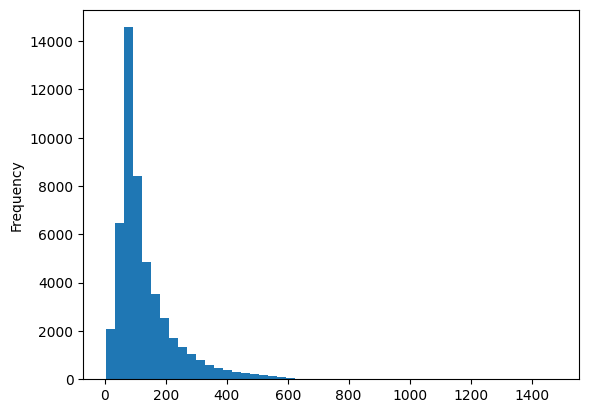

In [10]:
import matplotlib.pyplot as plt

df['len'].plot(kind='hist', bins=50)

In [11]:
MAX_SEQ_LENGTH = 150  # Max length of sentence to encode

vocab, train_dataset, test_dataset = load_dataset(df, MAX_SEQ_LENGTH)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

# 3. Train and evaluate model

In [22]:
import torch.nn as nn

class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True, nonlinearity='tanh'):
        super(RNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.nonlinearity = nonlinearity
        
        if self.nonlinearity != 'tanh' and self.nonlinearity != 'relu':
            raise ValueError('Invalid nonlinearity!')
        
        self.x2h = nn.Linear(input_size, hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=bias)
        
    def forward(self, x, hx=None):
        # Input
        #       x: of shape (batch_size, input_size)
        #
        #       hx: of shape (batch_size, hidden_size)
        #
        # Output
        #       y: of shape (batch_size, hidden_size)
        
        if hx is None:
            hx = torch.zeros(input.size(0), self.hidden_size)
            
        y = self.x2h(x) + self.h2h(hx)
        
        if self.nonlinearity == 'tanh':
            y = torch.tanh(y)
        else:
            y = torch.tanh(y)
            
        return y
    

class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_size, output_size, emb_matrix=None, dropout=0.5, bias=True, activation='tanh'):
        super(SimpleRNN, self).__init__()
        
        self.vocab_size = vocab_size
        self.emb_dim = emb_dim
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.bias =  bias
        
        if emb_matrix is None:
            self.embedding = nn.Embedding(vocab_size, emb_dim)
        else:
            self.embedding = nn.Embedding.from_pretrained(emb_matrix, freeze=False)
        
        
        if activation == 'tanh':
            self.rnn_cell = RNNCell(input_size=emb_dim,
                               hidden_size=hidden_size,
                               bias=bias,
                               nonlinearity='tanh')
        elif activation == 'relu':
            self.rnn_cell = RNNCell(input_size=emb_dim,
                                    hidden_size=hidden_size,
                                    bias=bias,
                                    nonlinearity='relu')
        else:
            raise ValueError("Invalid activated function!")
        
        self.fc = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.clf = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hx=None):
        # Input:
        #       x: of shape (batch_size, seq_length)
        #       hx: of shape (batch_size, hidden_size)
        # Output:
        #       y: of shape (batch_size, output_size)
        
        
        x = self.embedding(x) # of shape (batch_size, seq_length, emb_dim)
        
        if hx is None:
            if torch.cuda.is_available():
                hx = torch.zeros(x.size(0), self.hidden_size).cuda()
            else:
                hx = torch.zeros(x.size(0), self.hidden_size)
        
        # Forward by time
        for t in range(x.size(1)):
            hx = self.rnn_cell(x[:, t, :], hx)
        
        y = self.clf(hx)
        
        return y


class SimpleRNNWithPyTorch(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_size, output_size, emb_matrix=None, dropout=0.5, num_layers=1, bias=True, activation='tanh'):
        super(SimpleRNNWithPyTorch, self).__init__()
        
        # Embedding layer
        if emb_matrix is None:
            self.embedding = nn.Embedding(vocab_size, emb_dim)
        else:
            self.embedding = nn.Embedding.from_pretrained(emb_matrix, freeze=False)
        
        # RNN layer
        nonlinearity = 'relu' if activation == 'relu' else 'tanh'
        self.rnn = nn.RNN(input_size=emb_dim, 
                          hidden_size=hidden_size, 
                          num_layers=num_layers, 
                          bias=bias, 
                          nonlinearity=nonlinearity, 
                          batch_first=True)
        
        # Fully connected layers
        self.fc = nn.Linear(hidden_size, hidden_size)
        self.clf = nn.Linear(hidden_size, output_size)
        self.dropout_layer = nn.Dropout(dropout)
    
    def forward(self, x, hx=None):
        # Input:
        # x: (batch_size, seq_length)
        # hx: (num_layers, batch_size, hidden_size) or None
        
        x = self.embedding(x)  # Shape: (batch_size, seq_length, emb_dim)
        
        # RNN forward pass
        out, h_n = self.rnn(x, hx)  # out: (batch_size, seq_length, hidden_size)
                                    # h_n: (num_layers, batch_size, hidden_size)
        
        # Use the output of the last time step for classification
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)
        
        out = self.fc(out)   # Shape: (batch_size, hidden_size)
        out = self.dropout_layer(out)
        out = self.clf(out)  # Shape: (batch_size, output_size)
        
        return out
    

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_size, output_size, emb_matrix, num_layers=1):
        super(LSTMClassifier, self).__init__()

        # Embedding layer
        if emb_matrix is None:
            self.embedding = nn.Embedding(vocab_size, emb_dim)
        else:
            self.embedding = nn.Embedding.from_pretrained(emb_matrix, freeze=False)

        # LSTM layer from PyTorch
        self.lstm = nn.LSTM(input_size=emb_dim, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            bias=True, 
                            batch_first=True)
        
        # Fully connected layers
        self.fc = nn.Linear(hidden_size, hidden_size)
        self.clf = nn.Linear(hidden_size, output_size)

    def forward(self, x, hx=None):
        x = self.embedding(x)  # Shape: (batch_size, seq_length, emb_dim)

        # LSTM forward pass
        out, (h_n, c_n) = self.lstm(x)  # out: (batch_size, seq_length, hidden_size)
                                        # h_n: (num_layers, batch_size, hidden_size)
                                        # c_n: (num_layers, batch_size, hidden_size)

        # Use the output of the last time step for classification
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)

        out = self.fc(out)   # Shape: (batch_size, hidden_size)
        out = self.clf(out)  # Shape: (batch_size, output_size)

        return out


class StageRNN(SimpleRNN):
    def __init__(self, vocab_size, emb_dim, hidden_size, output_size, num_layers=1, emb_matrix=None, dropout=0.5, bias=True, activation='tanh'):
        super().__init__(vocab_size, emb_dim, hidden_size, output_size, emb_matrix, dropout, bias, activation)
        
        self.num_layers = num_layers
        
        self.rnn_cell_list = nn.ModuleList()
        for layer in range(num_layers):
            if layer == 0:
                self.rnn_cell_list.append(RNNCell(emb_dim, hidden_size, bias, activation))
            else:
                self.rnn_cell_list.append(RNNCell(hidden_size, hidden_size, bias, activation))
                
    
    def forward(self, x, hx=None):
        x = self.embedding(x)
        
        if hx is None:
            if torch.cuda.is_available():
                hx = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()
            else:
                hx = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
                
        outs = []
        hidden = []
        for layer in range(self.num_layers):
            hidden.append(hx[layer, :, :])

        for t in range(x.size(1)):
            for layer in range(self.num_layers):
                if layer == 0:
                    hidden_l = self.rnn_cell_list[layer](x[:, t, :], hx[layer])
                else:
                    hidden_l = self.rnn_cell_list[layer](hx[layer - 1], hx[layer])
                    
                hidden[layer] = hidden_l
            
            outs.append(hidden_l)
        
        y = outs[-1].squeeze()
        y = self.clf(y)
        
        return y

In [14]:
import tqdm

# Train model
def train(
    model, criterion, optimizer, train_loader, device=torch.device("cpu"), epochs=1
):
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        with tqdm.tqdm(train_loader, unit="batch") as tepoch:
            for inputs, labels in tepoch:
                tepoch.set_description(f"Epoch {epoch+1}/{epochs}")
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Clear gradient
                optimizer.zero_grad()

                # Forward
                outputs = model(inputs)                    

                # Compute loss
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                # Compute accuracy
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

            epoch_loss = running_loss / len(train_loader)
            epoch_acc = correct / total
            print(
                f"|----> Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}"
            )

    return running_loss / len(train_loader)


# Evaluate model
def evaluate(model, test_loader, device=torch.device("cpu")):
    model.to(device)
    # Evaluate model on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy


# Save model
def save(model, filepath):
    torch.save(model.state_dict(), filepath)


In [15]:
# Init model
vocab_size = len(vocab)
embedding_dim = 100
hidden_size = 20
output_size = 2  # Positive/Negative
num_layers = 2

pretrained_path = "pretrained_emb/glove.twitter.27B.100d.txt"
pretrained_embeddings = load_pretrained_embeddings(pretrained_path, embedding_type='glove')

# Create embedding matrix
embedding_matrix = create_embedding_matrix(vocab, pretrained_embeddings, embedding_dim)


In [23]:
# simple_rnn = SimpleRNN(vocab_size, embedding_dim, hidden_size, output_size, embedding_matrix)
# simple_rnn_with_pytorch = SimpleRNNWithPyTorch(vocab_size, embedding_dim, hidden_size, output_size, embedding_matrix, num_layers=num_layers)
# lstm = LSTMClassifier(vocab_size, embedding_dim, hidden_size, output_size, embedding_matrix, num_layers)
rnn = StageRNN(vocab_size, embedding_dim, hidden_size, output_size, num_layers, embedding_matrix)

In [17]:
def check_vocab_coverage(vocab, pretrained_embeddings):
    in_vocab = []
    out_vocab = []

    for word in vocab.keys():
        if word in pretrained_embeddings:
            in_vocab.append(word)
        else:
            out_vocab.append(word)

    return in_vocab, out_vocab

In [18]:
iv, ov = check_vocab_coverage(vocab, pretrained_embeddings)

In [19]:
coverage = len(iv) / len(vocab) * 100
print(f"Coverage: {coverage:.2f}%")

Coverage: 76.79%


In [24]:
# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.005)

In [25]:
avg_loss = train(model=rnn, criterion=criterion, optimizer=optimizer, train_loader=train_loader, device=device, epochs=5)

Epoch 1/5: 100%|██████████| 625/625 [00:34<00:00, 18.01batch/s]


|----> Loss: 0.6933, Accuracy: 0.4960


Epoch 2/5: 100%|██████████| 625/625 [00:35<00:00, 17.67batch/s]


|----> Loss: 0.6932, Accuracy: 0.5007


Epoch 3/5: 100%|██████████| 625/625 [00:34<00:00, 17.90batch/s]


|----> Loss: 0.6932, Accuracy: 0.5000


Epoch 4/5: 100%|██████████| 625/625 [00:34<00:00, 17.89batch/s]


|----> Loss: 0.6932, Accuracy: 0.4999


Epoch 5/5: 100%|██████████| 625/625 [00:34<00:00, 18.35batch/s]

|----> Loss: 0.6932, Accuracy: 0.5025


In [26]:
acc = evaluate(model=rnn, test_loader=test_loader, device=device)

Test Accuracy: 0.4990


In [27]:
save(rnn, 'save/models/stage_rnn_1.pth')

# 4. Hyperparameter tuning

In [24]:
# from itertools import product
# from torch.utils.data import DataLoader

# from torch.optim import Adam, SGD

# def hyper_tuning(
#     model_class,  # Model class (e.g., TextCNN, RNN)
#     param_grid,   # Dictionary of hyperparameters
#     data_loader_fn,  # DataLoader function (e.g., DataLoader)
#     train_fn,  # Training function (e.g., train)
#     train_dataset,  # Training dataset
#     device=torch.device('cpu'),  # Device to run on
#     epochs=5  # Number of epochs
# ):
#     param_combinations = list(product(*param_grid.values()))
    
#     best_params = None
#     best_loss = float('inf')
#     for params in param_combinations:
#         param_dict = dict(zip(param_grid.keys(), params))
#         print(f"\nTesting with parameters: {param_dict}")
        
#         # Create DataLoader
#         train_loader = data_loader_fn(train_dataset, batch_size=param_dict['batch_size'], shuffle=True)
        
#         # Initialize model
#         model = model_class(**param_dict['model_params'])
        
#         # Loss function
#         criterion = nn.CrossEntropyLoss()
        
#         # Optimizer
#         optimizer_class = SGD if param_dict['optimizer'] == 'SGD' else Adam
#         optimizer = optimizer_class(model.parameters(), lr=param_dict['learning_rate'])

#         # Train and calculate loss
#         avg_loss = train_fn(
#             model=model,
#             criterion=criterion,
#             optimizer=optimizer,
#             train_loader=train_loader,
#             device=device,
#             epochs=epochs
#         )
        
#         # Update best parameters
#         if avg_loss < best_loss:
#             best_loss = avg_loss
#             best_params = param_dict

#     return best_params, best_loss


In [25]:
# param_grid = {
#     'batch_size': [16, 32, 64],
#     'learning_rate': [1e-3, 5e-3],
#     'optimizer': ['SGD', 'Adam'],
#     'model_params': [
#         {
#             'vocab_size': len(vocab), 
#             'embedding_dim': emb_dim, 
#             'hidden_size': [50, 100], 
#             'output_size': 2
#         }
#         for emb_dim in [50, 100, 150]
#     ]
# }

# best_params, best_loss = hyper_tuning(
#     model_class=SimpleRNN,
#     param_grid=param_grid,
#     data_loader_fn=DataLoader,
#     train_fn=train,
#     train_dataset=train_dataset,
#     device=device,
#     epochs=5
# )

# print("Best Hyperparameters:", best_params)
# print("Best Loss:", best_loss)


In [26]:
# print(f'Best params: {best_params}\n\nBest loss: {best_loss}')

In [27]:
# save(model=model, filepath='save/models/best_model.pth')

In [28]:
# torch.save(best_params, 'save/params/best_params.pth')